In [25]:
import pandas as pd

In [38]:
#UserInfo.tsv
business_demography = pd.read_csv('/home/chris/datasets/european_union/test.tsv', delimiter='\t', encoding='utf-8')
#print(list(business_by_demography.columns.values)) #file header
business_demography.columns

Index(['GEO,LEG_FORM,INDIC_SB,NACE_R2\TIME', '2006', '2007', '2008', '2009',
       '2010', '2011', '2012', '2013', '2014', '2015'],
      dtype='object')

In [39]:
business_demography = business_demography.rename(columns={'GEO,LEG_FORM,INDIC_SB,NACE_R2\TIME':'Countries'})

## Transpose table and generate new vertical index

In [40]:
#Fill empty cells with zeros
business_demography = business_demography.fillna(0)
business_demography.set_index('Countries',inplace=True)
business_demography = business_demography.transpose()

## There are certain flags in the table to indicate special features of the data

### Available flags
* b	break in time series
* c	confidential
* d	definition differs, see metadata
* e	estimated
* f	forecast
* i	see metadata (phased out)
* n	not significant
* p	provisional
* r	revised
* s	Eurostat estimate (phased out)
* u	low reliability
* z	not applicable

It is not recommendable in general to drop the information contained by these flags, but for first exploration purposes it should not do too much harm. The flags can easily remove by filling them all into a list and strip them by looping over this list. 

In [41]:
flags = ['b', 'c', 'd','e','f','i','n','p','r','s','u','z']

In [42]:
for column in business_demography.columns:  
    column = str(column)
    for flag in flags:
        business_demography[column] = business_demography[column].str.strip(flag)

## Replace the lengthy name of Germany

In [43]:
for column in business_demography.columns:  
    column = str(column)
    column_content = column.split(',')[0]
    if 'Germany' in column_content:
        old_german_name = 'Germany (until 1990 former territory of the FRG)'
        new_german_name = 'Germany'
        new_column = column.replace(old_german_name,new_german_name)
        business_demography = business_demography.rename(index=str,columns={column:new_column})

## Replace the colons by zeros

In [44]:
business_demography = business_demography.replace(':',0)

In [45]:
business_demography =  business_demography.apply(pd.to_numeric, args=('coerce',))
business_demography = business_demography.fillna(0)

## Drop the columns that should contain average data on the EU

In [46]:
type(business_demography)

pandas.core.frame.DataFrame

In [47]:
business_demography.drop(list(business_demography.filter(regex = 'European Union')), axis = 1, inplace = True)

In [48]:
type(business_demography)

pandas.core.frame.DataFrame

### Drop the years 2006-2008

In [49]:
business_demography.drop('2006').drop('2007').drop('2008')

Countries,"Belgium,Total,Net business population growth - percentage,Business economy except activities of holding companies","Bulgaria,Total,Net business population growth - percentage,Business economy except activities of holding companies","Czech Republic,Total,Net business population growth - percentage,Business economy except activities of holding companies","Denmark,Total,Net business population growth - percentage,Business economy except activities of holding companies","Germany,Total,Net business population growth - percentage,Business economy except activities of holding companies","Estonia,Total,Net business population growth - percentage,Business economy except activities of holding companies","Ireland,Total,Net business population growth - percentage,Business economy except activities of holding companies","Greece,Total,Net business population growth - percentage,Business economy except activities of holding companies","Spain,Total,Net business population growth - percentage,Business economy except activities of holding companies","France,Total,Net business population growth - percentage,Business economy except activities of holding companies",...,"Romania,Limited liability enterprise,Employment share of enterprise deaths: number of persons employed in the reference period (t) among enterprise deaths divided by the number of persons employed in t among the stock of active enterprises in t - percentage,Business economy except activities of holding companies","Slovenia,Limited liability enterprise,Employment share of enterprise deaths: number of persons employed in the reference period (t) among enterprise deaths divided by the number of persons employed in t among the stock of active enterprises in t - percentage,Business economy except activities of holding companies","Slovakia,Limited liability enterprise,Employment share of enterprise deaths: number of persons employed in the reference period (t) among enterprise deaths divided by the number of persons employed in t among the stock of active enterprises in t - percentage,Business economy except activities of holding companies","Finland,Limited liability enterprise,Employment share of enterprise deaths: number of persons employed in the reference period (t) among enterprise deaths divided by the number of persons employed in t among the stock of active enterprises in t - percentage,Business economy except activities of holding companies","Sweden,Limited liability enterprise,Employment share of enterprise deaths: number of persons employed in the reference period (t) among enterprise deaths divided by the number of persons employed in t among the stock of active enterprises in t - percentage,Business economy except activities of holding companies","United Kingdom,Limited liability enterprise,Employment share of enterprise deaths: number of persons employed in the reference period (t) among enterprise deaths divided by the number of persons employed in t among the stock of active enterprises in t - percentage,Business economy except activities of holding companies","Norway,Limited liability enterprise,Employment share of enterprise deaths: number of persons employed in the reference period (t) among enterprise deaths divided by the number of persons employed in t among the stock of active enterprises in t - percentage,Business economy except activities of holding companies","Switzerland,Limited liability enterprise,Employment share of enterprise deaths: number of persons employed in the reference period (t) among enterprise deaths divided by the number of persons employed in t among the stock of active enterprises in t - percentage,Business economy except activities of holding companies","Former Yugoslav Republic of Macedonia, the,Limited liability enterprise,Employment share of enterprise deaths: number of persons employed in the reference period (t) among enterprise deaths divided by the number of persons employed in t among the stock of active enterprises in t - 

### Get all unique country names and create a dictionary containing dataframes for each country

In [50]:
countries_unique = []
for column in business_demography.columns:
    column_content = str(column).split(",")
    countries_unique.append(column_content[0])
countries_unique = list(set(countries_unique))
    

In [51]:
import re
df = {}

for country_name in countries_unique:
    df[country_name] = business_demography.filter(regex=country_name)

In [52]:
## Plot the 

In [53]:
import plotly.plotly as py
import plotly.graph_objs as go

from datetime import datetime
import pandas_datareader.data as web

sole = business_demography['Germany,Sole proprietorship,Net business population growth - percentage,Business economy except activities of holding companies']    
total = business_demography['Germany,Total,Net business population growth - percentage,Business economy except activities of holding companies']
partnership = business_demography['Germany,Partnership, co-operatives, associations, etc.,Net business population growth - percentage,Business economy except activities of holding companies']
limiteds = business_demography['Germany,Limited liability enterprise,Net business population growth - percentage,Business economy except activities of holding companies']



sole_proprietorship = go.Scatter(x=df['Germany'].index, y=sole, name='Sole proprietorship')
total_growth = go.Scatter(x=df['Germany'].index, y=total, name='Total growth')
partnerships = go.Scatter(x=df['Germany'].index, y=partnership, name='Partnerships & Associates')
limiteds = go.Scatter(x=df['Germany'].index, y=limiteds, name='Limited liability')

data = [sole_proprietorship,total_growth,partnerships,limiteds]

layout = dict(
    title = "Growth comparison of different legal forms in Germany",
    xaxis = dict(
        range = ['2009','2015'])
)

fig = dict(data=data, layout=layout)
py.iplot(fig)

## The growth of each legalform during the years 2009-2015

In [54]:
import plotly.plotly as py
import plotly.graph_objs as go

from datetime import datetime
import pandas_datareader.data as web


business_demography['Sole proprietorship growth'] = business_demography.filter(regex='Sole proprietorship,Net business population growth', axis=1).mean(axis=1)
business_demography['Total growth in the EU'] = business_demography.filter(regex='Total,Net business population growth', axis=1).mean(axis=1)
business_demography['Partnership growth'] = business_demography.filter(regex='Partnership, co-operatives, associations, etc.,Net business population growth', axis=1).mean(axis=1)
business_demography['Limiteds growth'] = business_demography.filter(regex='Limited liability enterprise,Net business population growth', axis=1).mean(axis=1)



sole_proprietorship = go.Scatter(x=business_demography.index, y=business_demography['Sole proprietorship growth'], name='Sole proprietorship')
total_growth = go.Scatter(x=business_demography.index, y=business_demography['Total growth in the EU'], name='Total growth')
partnerships = go.Scatter(x=business_demography.index, y=business_demography['Partnership growth'], name='Partnerships & Associates')
limiteds = go.Scatter(x=business_demography.index, y=business_demography['Limiteds growth'], name='Limited liability')

data = [sole_proprietorship,total_growth,partnerships,limiteds]

layout = dict(
    title = "Growth comparison of different legal forms across the EU",
    xaxis = dict(
        range = ['2009','2015'])
)

fig = dict(data=data, layout=layout)
py.iplot(fig)

In [55]:
### Investigate the correlations 

In [59]:
sole_proprietorship = business_demography.filter(regex='Sole proprietorship,Net business population growth')


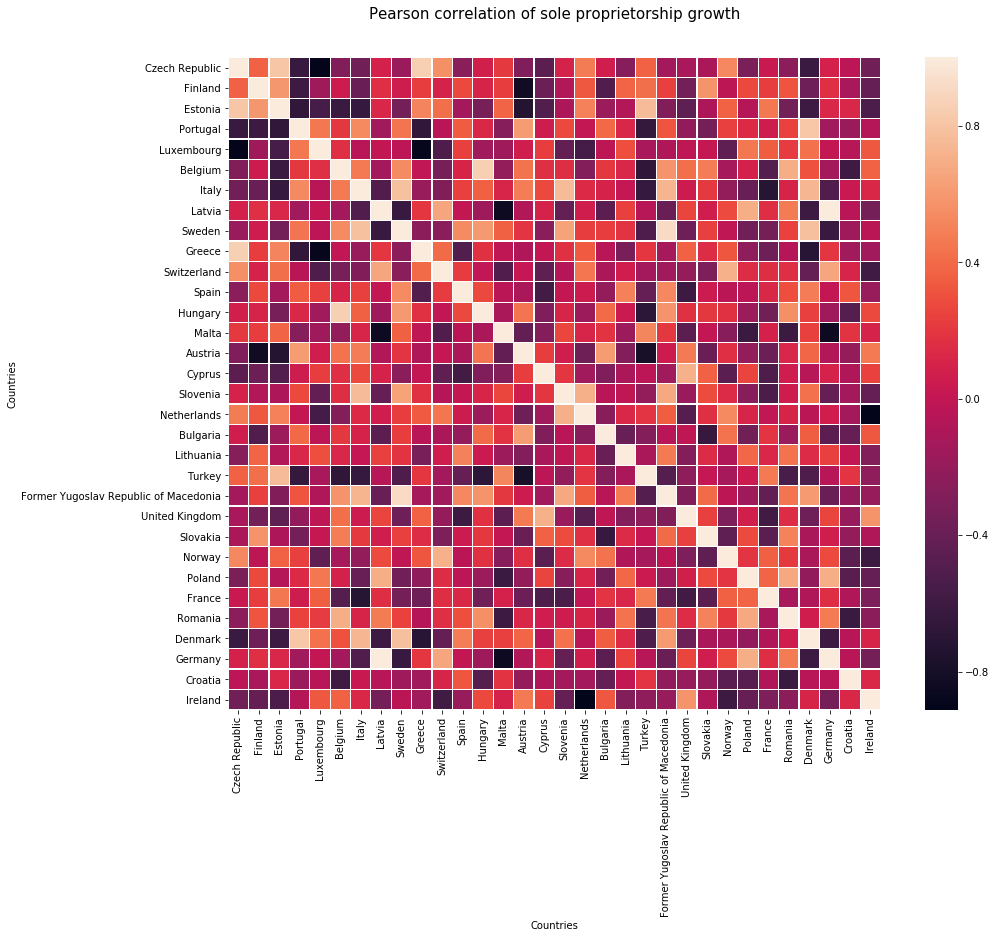

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,12))
plt.title('Pearson correlation of sole proprietorship growth', y=1.05, size=15)
plot = sns.heatmap(sole_proprietorship.corr(), xticklabels=countries_unique, yticklabels=countries_unique,linewidths=0.1,vmax=1.0, square=True, linecolor='white')
plt.show()

# Look at the total net growth of businesses in the eurozone

* Calculate the average net growth of businesse for each country in the period of measurement 2009-2015
* To visualize the data on a choropleth map the standard country codes are attached to each dataframe entry 

In [66]:
import pycountry
import numpy as np

mean_growth = []
country_names = []
country_codes = []

mapping = {country.name: country.alpha3 for country in pycountry.countries}

for column in business_demography.columns:
    if 'Total,Net business population growth' in column:
        new_column_name = column.split(',')[0]
        #country_names.append(new_column_name)
        mean_growth.append(business_demography[column].mean())
        country_codes.append((new_column_name, mapping.get(new_column_name, 'No country found')))

mean_growth_country = pd.DataFrame(np.column_stack([country_codes,mean_growth]), columns=['Country', 'Code', 'Mean growth'])

In [67]:
#mean_growth_country['Country'].drop("European Union*")

In [68]:
import plotly.plotly as py
import plotly.graph_objs as go

data = [go.Bar(
            x = mean_growth_country['Country'],
            y = mean_growth_country['Mean growth']
        
    )]
layout = go.Layout(
    title='Business growth between 2009 and 2015',
)

fig = go.Figure(layout=layout)
py.iplot(data, filename='basic-bar')

In [69]:
mean_growth_country = mean_growth_country.drop(mean_growth_country.index[30])

In [70]:
import plotly.plotly as py
import pandas as pd

data = [ dict(
        type = 'choropleth',
        locations = mean_growth_country['Code'],
        z = mean_growth_country['Mean growth'],
        text = mean_growth_country['Country'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '%',
            title = 'Average growth of business population'),
      ) ]

layout = dict(
    title = 'Average growth of business population in the years 2009-2015',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )